# TP-Discrétisation avec arbres de décision

Nous allons apprendre à effectuer une discrétisation avec des arbres de décision en utilisant le jeu de données Titanic.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

## Charger les variables numériques du jeu de données Titanic

In [14]:
data = pd.read_csv('data/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


## Séparer le jeu de données en trainning set et test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

## Les variables Age et tarif(fare) contiennent des données manquantes, que je remplirai en extrayant un échantillon aléatoire de la variable.

In [16]:
def impute_na(data, variable):
    df = data.copy()
    
     # échantillonnage aléatoire
    df[variable+'_random'] = df[variable]
    # extraire l'échantillon aléatoire pour remplir le na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

## Remplacer NA dans les ensembles de train et de test

In [17]:
X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

## Age

In [18]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,21.0,7.7250
686,22.0,7.7250


## Exemple: créer une arbre de classification(modele) en utilisant l'âge pour prédire les survivants

In [19]:
tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:,1]

X_train.head(10)

,age,fare,Age_tree
501,13.0,19.5000,0.366059
588,4.0,23.0000,0.529412
402,30.0,13.8583,0.366059
1193,21.0,7.7250,0.366059
686,22.0,7.7250,0.366059
971,16.0,7.8792,0.366059
117,30.0,56.9292,0.366059
540,2.0,26.0000,0.529412
294,49.0,110.8833,0.450704
261,35.0,26.2875,0.366059


## Explorons le nombre de points finaux créés par l'arbre

In [22]:
X_train['Age_tree'].unique()

array([0.36605891, 0.52941176, 0.45070423, 0.        , 1.        ])

Un arbre de profondeur 2, fait 2 scissions, générant donc 4 'bucket', c'est pourquoi nous voyons 4 probabilités différentes dans la sortie ci-dessus.

### Relation monotone avec la cible

Text(0, 0.5, 'Survived')

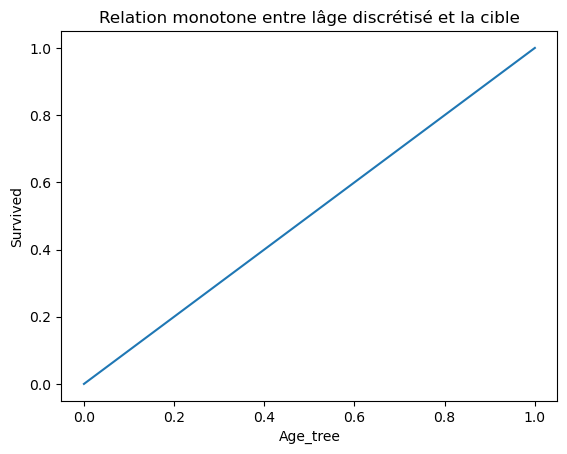

In [23]:
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Relation monotone entre l''âge discrétisé et la cible')
plt.ylabel('Survived')

### Nombre de passagers par intervalles/bin

<AxesSubplot:xlabel='Age_tree'>

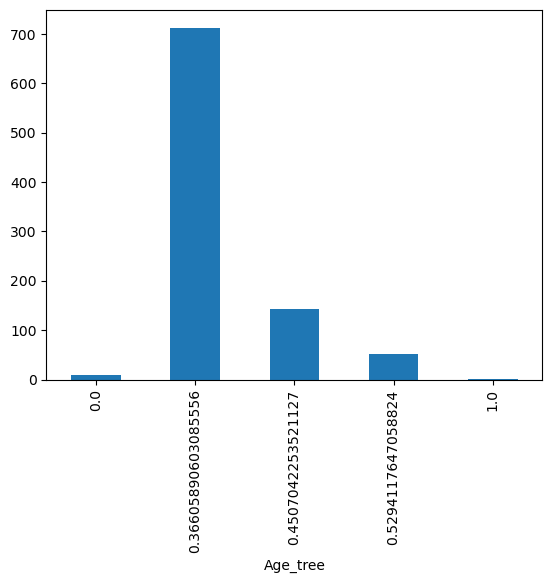

In [24]:
X_train.groupby(['Age_tree'])['age'].count().plot.bar()

## âge médian dans chaque compartiment(intervalle) créé par l'arbre

<AxesSubplot:xlabel='Age_tree'>

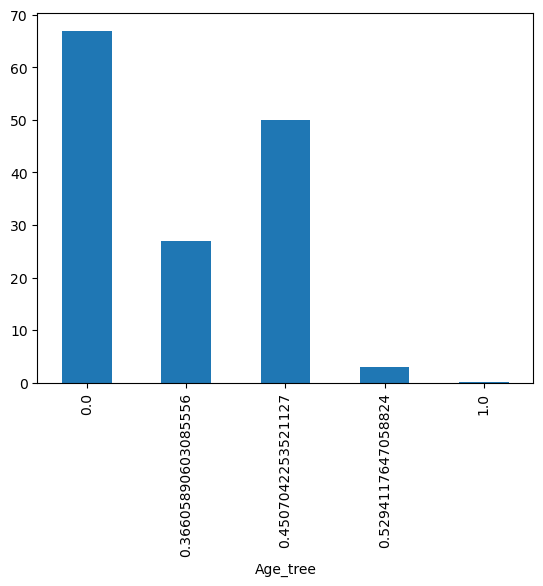

In [25]:
X_train.groupby(['Age_tree'])['age'].median().plot.bar()

#### Voyons les buckets limites d'age générés par l'arbre en capturant l'âge minimum et maximum pour chaque tranche.

In [26]:
pd.concat( [X_train.groupby(['Age_tree'])['age'].min(),
            X_train.groupby(['Age_tree'])['age'].max()], axis=1)

,age,age
Age_tree,,
0.000000,65.0000,74.0000
0.366059,9.0000,44.0000
0.450704,45.0000,64.0000
0.529412,0.7500,8.0000
1.000000,0.1667,0.1667


Ainsi, l'arbre de décision a généré les intervalles: 65-74, 9-44, 45-64 et 0.7-8 et 0-16-0.16, avec des probabilités de survie de .0, .36, .45, .52 et .1 respectivement.

### Visualisation de l'arbre

Nous pouvons continuer et visualiser l'arbre en enregistrant le modèle dans un fichier,et ouvrir ce fichier dans le lien indiqué ci-dessous

In [27]:
with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# allez ici pour ouvrir le fichier: http://webgraphviz.com

    . C'est ce que vous devriez voir si vous faites ce qui est décrit dans la cellule précédente

    . J'ai enregistré l'image que vous devez récupérer sur le serveur ci-dessus dans un png,
    
    . Le graphique indique les seuils d'âge à chaque nœud, ainsi que le nombre d'échantillons à chaque nœud, et le gini

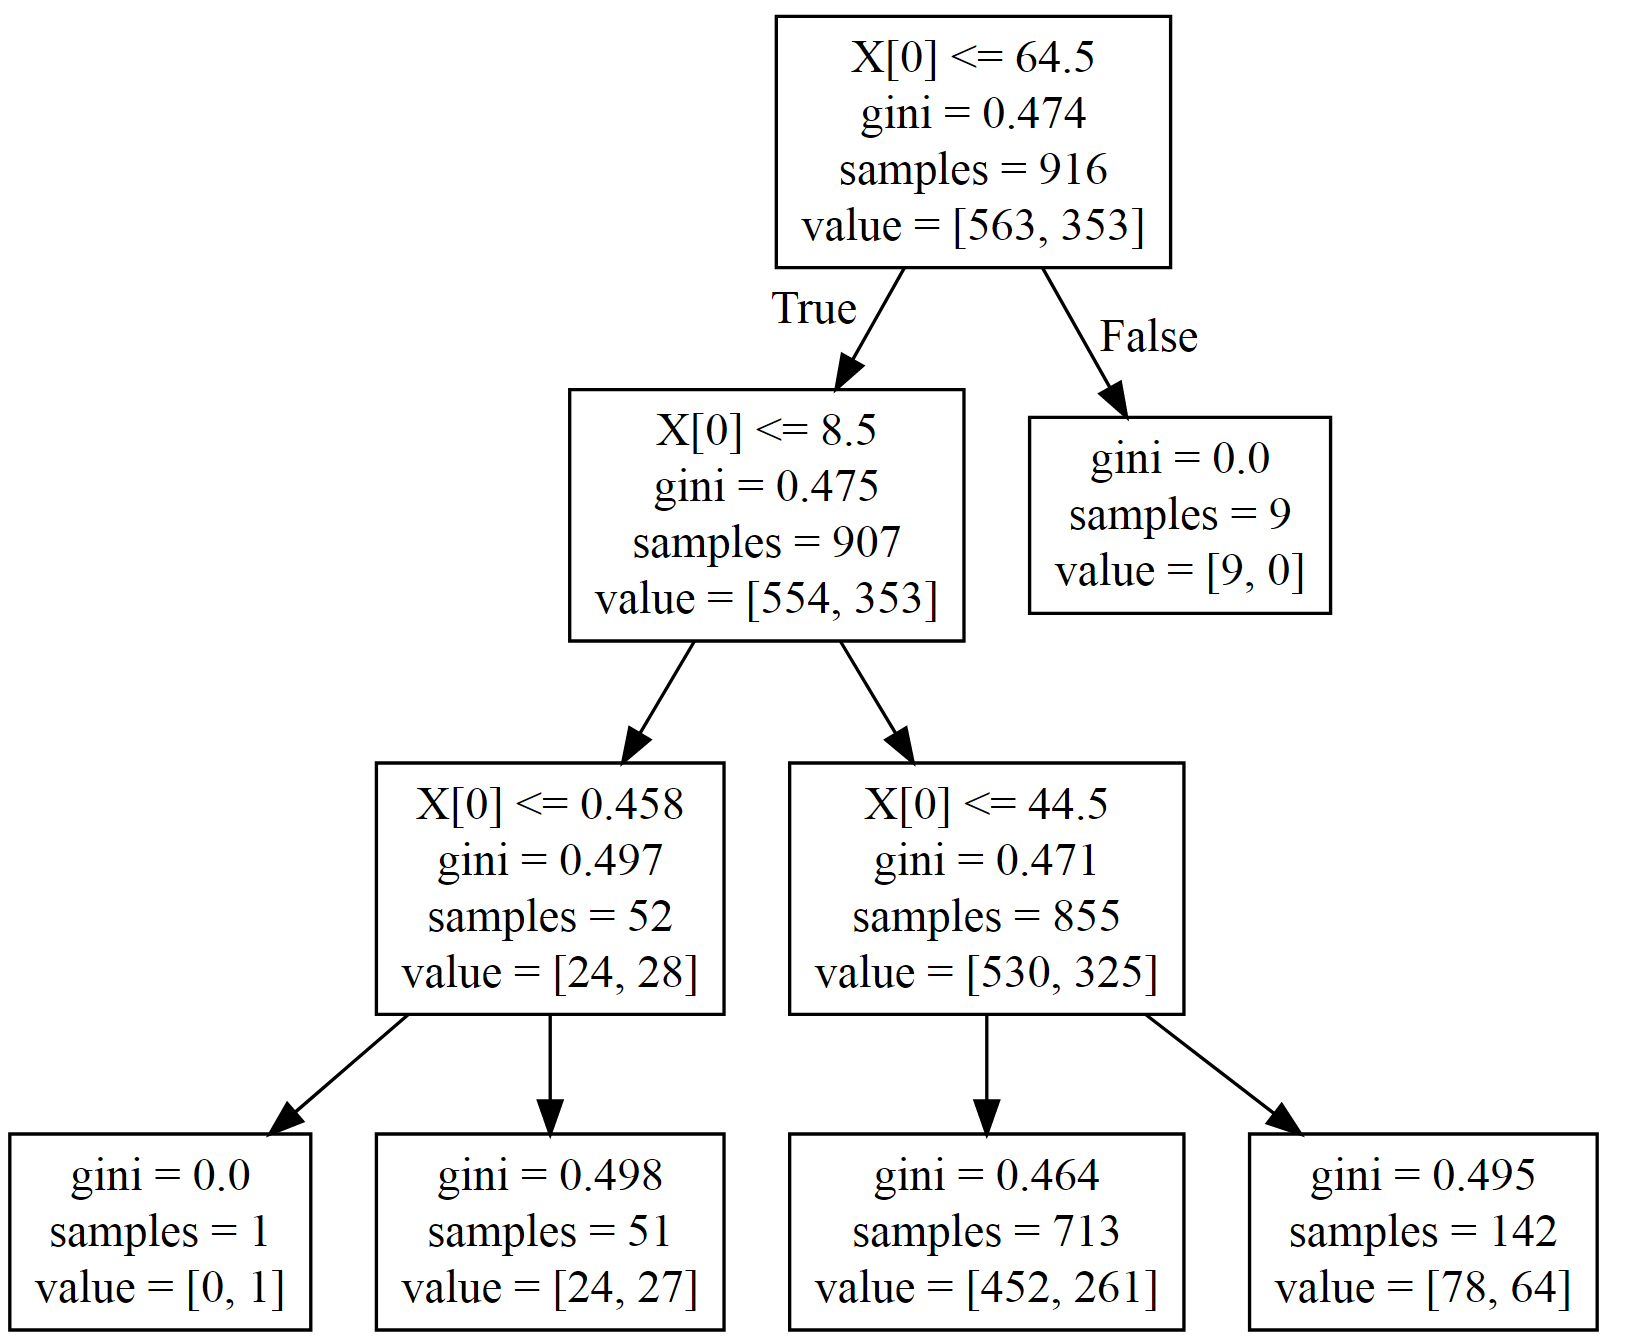

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)

### Étendons les résultats de l'arbre à l'ensemble de test et explorons la relation monotone

Text(0, 0.5, 'Survived')

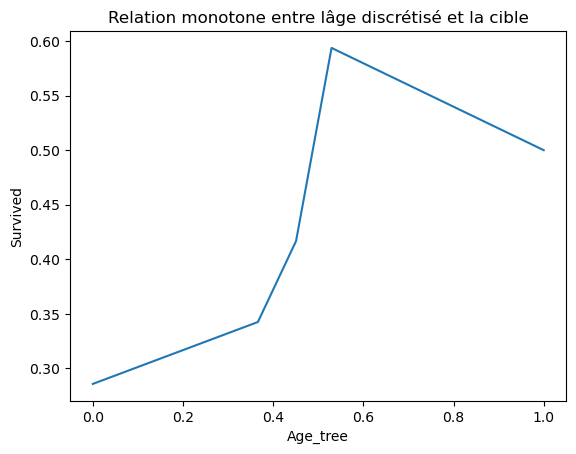

In [30]:
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# relation monotone avec la cible

pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Relation monotone entre l''âge discrétisé et la cible')
plt.ylabel('Survived')



Àttention: Nous pouvons voir que la relation monotone n'est pas maintenue dans l'ensemble de test, ce qui indique probablement que l'arbre que nous construisons était sur-ajusté à l'ensemble de train.
Construire l'arbre de décision optimal

Il existe un certain nombre de paramètres que nous pourrions optimiser pour obtenir la meilleure division d'intervalle à l'aide d'arbres de décision.

J'optimiserai la profondeur de l'arbre pour cet exemple. Mais rappelez-vous que nous pourrions également optimiser les paramètres restants de l'arbre de décision.

Visitez le site Web sklearn pour voir quels autres paramètres peuvent être optimisés.


In [31]:
# Construisez des arbres de différentes profondeurs et calculez le roc-auc de chaque arbre
# choisissez la profondeur qui génère le meilleur roc-auc

score_ls = []  # ici nous stockons le roc auc
score_std_ls = []  # ici nous stockons l'écart type du roc_auc

for tree_depth in [1, 2, 3, 4]:

    # appeler le modèle
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # former le modèle en utilisant la validation croisée k=3

    scores = cross_val_score(
        tree_model, X_train['age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    
    # enregistrer les paramètres
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# capturer les paramètres dans un dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.501610,0.010728
1,2,0.526407,0.018134
2,3,0.515982,0.029126
3,4,0.527269,0.024281


On obtient le meilleur roc-auc en utilisant des profondeurs de 2 (même valeur que la profondeur 4 mais std plus petite). Je vais sélectionner une profondeur de 2 pour continuer.

### Transformez la variable en utilisant l'arbre

In [32]:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:, 1]
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:, 1]

### Relation monotone avec la cible dans le train

Text(0, 0.5, 'Survived')

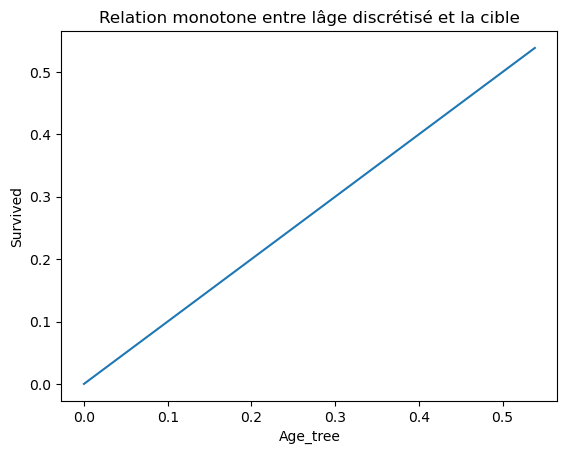

In [33]:
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Relation monotone entre l''âge discrétisé et la cible')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

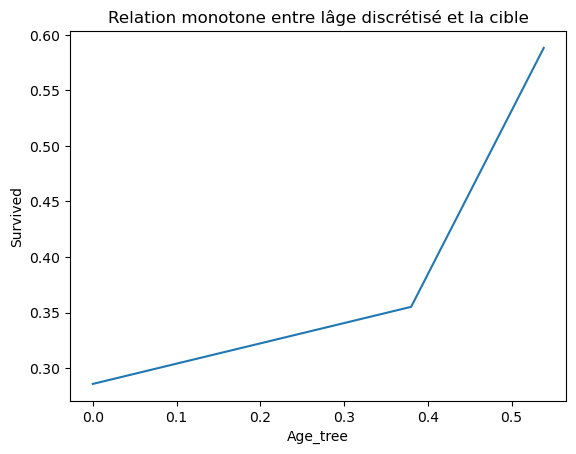

In [34]:
# et dans l'ensemble de test

X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# relation monotone avec la cible
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Relation monotone entre l''âge discrétisé et la cible')
plt.ylabel('Survived')

La relation monotone est également maintenue dans l'ensemble de test.